## Poetry generation

Main goal of the project - generate some poetry using RNNs. 

Here we use The Shakespeare sonnets as data for learning. So that, the result poetry will be in Shakespeare's style.

File `sonnets.txt` is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch, torch.nn as nn
import torch.nn.functional as F

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is going in the next cell

In [2]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

We want to predict complex text, but let's simplify task and lowercase all the symbols.

Now variable `text` is a list of strings.

In [3]:
text = "".join(text)
text = text.lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Let's put all the characters from the text into variable `tokens`.

In [4]:
# Разбиваем на токены
tokens = list(set(text))
num_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
id_to_token = {idx: token for idx, token in enumerate(tokens)}
# dict <char>:<index>
token_to_id = {token: idx for idx, token in enumerate(tokens)}

encoded_text = np.array([token_to_id[i] for i in text])

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [6]:
# Создаем тренировочные данные
def train_data(data, seq_len, batch_size):
    pairs = []
    n_batches = len(data) // (seq_len * batch_size)
    data = data[:n_batches * seq_len * batch_size]
    data = data.reshape((batch_size, -1))
    for n in range(0, data.shape[1], seq_len):
        x = data[:, n:n+seq_len]
        y = np.roll(x, -1, axis=1)
        x = torch.tensor(x, dtype=torch.long)
        y = torch.tensor(y, dtype=torch.long)
        pairs.append((x, y))

    return pairs

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN

In [7]:
# Параметры модели
embed_size = 64
rnn_hidden_size = 128
num_layers = 1
seq_length = 128
batch_size = 64

In [8]:
# RNN
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens, embed_size, rnn_hidden_size, num_layers):
        super(CharRNNLoop, self).__init__()

        self.embedding = nn.Embedding(num_tokens, embed_size)
        self.rnn = nn.RNN(embed_size, rnn_hidden_size, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_hidden_size, num_tokens)
    
    def forward(self, x, hidden):
        x = self.embedding(x)
        h_seq, hidden = self.rnn(x, hidden)
        h_seq = self.hid_to_logits(h_seq)
        return h_seq, hidden
    
    # Изначальное скрытое состояние
    def init_hidden(self, batch_size):
        return torch.zeros(num_layers, batch_size, rnn_hidden_size, requires_grad=True)

In [9]:
model_rnn = CharRNNLoop(num_tokens, embed_size, rnn_hidden_size, num_layers)
optimizer = torch.optim.Adam(model_rnn.parameters())
loss_func = nn.CrossEntropyLoss()
history_rnn = []

In [10]:
# Обучение
model_rnn.train()
for epoch in tqdm(range(1000)):
    hidden = model_rnn.init_hidden(batch_size)
    pairs = train_data(encoded_text, seq_length, batch_size)
    for x, y in pairs:
        hidden = hidden.detach()
        out, hidden = model_rnn(x, hidden)
        loss = loss_func(out.reshape(-1, num_tokens), y.reshape(-1))

        # Зануление градиентов на кажом шаге
        optimizer.zero_grad()
        # Обратное распространение loss
        loss.backward()
        optimizer.step()

    history_rnn.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [02:08<00:00,  7.77it/s]


Plot the loss function (axis X: number of epochs, axis Y: loss function).

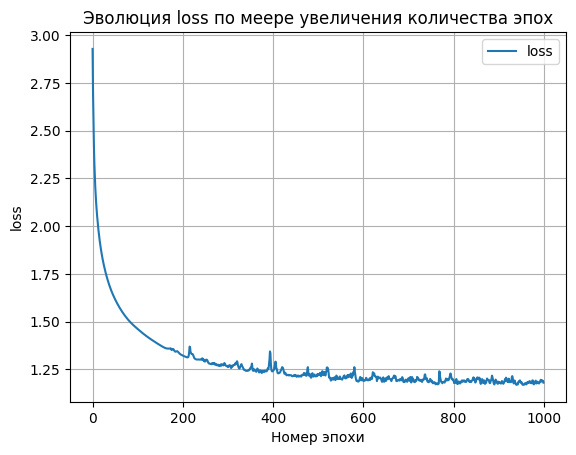

In [11]:
plt.plot(history_rnn, label='loss')
plt.legend()
plt.grid(True)
plt.xlabel('Номер эпохи')
plt.ylabel('loss')
plt.title('Эволюция loss по меере увеличения количества эпох')
plt.show()

In [12]:
def generate_sample(model, seed_phrase='start ', max_length=500, temperature=1.0):
    
    model.eval()
    hidden = model.init_hidden(1)
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    generated_text = seed_phrase

    for _ in range(max_length - len(seed_phrase)):
        out, hidden = model(x_sequence, hidden)
        p_next = F.softmax(out.squeeze().div(temperature), dim=-1)
        next_ix = torch.multinomial(p_next, 1)[-1].item()
        generated_text += id_to_token[next_ix]
        # подадим новый токен next_ix на вход следующей иттерации
        x_sequence = torch.tensor([[next_ix]], dtype=torch.int64)
        
    return generated_text

In [13]:
# пример сгенерированного текста
print(generate_sample(model_rnn, max_length=500, temperature=1.0))

start leave the straight in mars' from thee;
  why speak,
      ank the world wink in the formance delights
  my farth in my thou be discomp dost his glass thy self a tend,
  in flatter!
  the easurance offender look is br for love's lines on the state,
  and he bad mind.
  how many of 'wilt;
    he gas ent and the pieft the summer that to know her infeck the warse,
  reses none on mind and ill tear art care i replence hold the line,
  the eyes are wentle right dobbsich mine, remeals and, that p


Parameter `temperature` influences on probability distribution of tokens. The more temperature is the more simmilar to normal our distribution is

In [14]:
for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f'Temperature: {temperature}')
    print(generate_sample(model_rnn, max_length=200, temperature=temperature))
    print()

Temperature: 0.1
start i conself of blookly doth some count of thee thou shalt the ease all thee in the sun in the sun in sweet love thee with the sun they so doth dear doth me dost thou art the lies,
  have should al

Temperature: 0.2
start i constants of your self thou art not the enough thee with the lies,
  which i constant to men the lessing that the world his not for my self the eyes have so recees not all thy beauty doth some

Temperature: 0.5
start in the world will happy thou art false give thee so for me world stands should all they with ment, but 'ight
  and with love is a taker and love is their dateons;
  when i can me thy beauty they

Temperature: 1.0
start of sighll'd,
  on dear-consake your self that d thy obsequar all nothing they, i to copeis wooth, what my alow,
  east to their moanday,
  nor been thy self in seek! dranking do prove wonder to 

Temperature: 2.0
start may me?
  o! ty penl'trdly stoour'' ripe;
  jorce! not revised sevorn:
  for himol'st is pillgragnesp

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results. All intermidiate steps are the same as for RNN.

In [15]:
# Параметры модели
embed_size = 64
lstm_hidden_size = 128
num_layers = 1
seq_length = 128
batch_size = 64

In [16]:
# LSTM
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens, embed_size, lstm_hidden_size, num_layers):
        super(CharLSTMLoop, self).__init__()

        self.embedding = nn.Embedding(num_tokens, embed_size)
        self.rnn = nn.LSTM(embed_size, lstm_hidden_size, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(lstm_hidden_size, num_tokens)
    
    def forward(self, x, hidden):
        x = self.embedding(x)
        h_seq, hidden = self.rnn(x, hidden)
        h_seq = self.hid_to_logits(h_seq)
        return h_seq, hidden
    
    # Изначальное скрытое состояние
    def init_hidden(self, batch_size):
        return (torch.zeros(num_layers, batch_size, lstm_hidden_size, requires_grad=True),
                torch.zeros(num_layers, batch_size, lstm_hidden_size, requires_grad=True))

In [17]:
model_lstm = CharLSTMLoop(num_tokens, embed_size, lstm_hidden_size, num_layers)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters())
loss_func = nn.CrossEntropyLoss()

history_lstm = []

In [18]:
# Обучение
model_lstm.train()
for epoch in tqdm(range(1000)):
    hidden = model_lstm.init_hidden(batch_size)
    pairs = train_data(encoded_text, seq_length, batch_size)
    for x, y in pairs:
        hidden = tuple([h.detach() for h in hidden])    
        output, hidden = model_lstm(x, hidden)
        loss = loss_func(output.reshape(-1, num_tokens), y.reshape(-1))

        # Зануление градиентов на кажом шаге
        optimizer_lstm.zero_grad()
        # Обратное распространение loss
        loss.backward()
        optimizer_lstm.step()

    history_lstm.append(loss.item())

100%|██████████| 1000/1000 [06:27<00:00,  2.58it/s]


Let's plot the loss function of the number of epochs. Does the final loss become better?

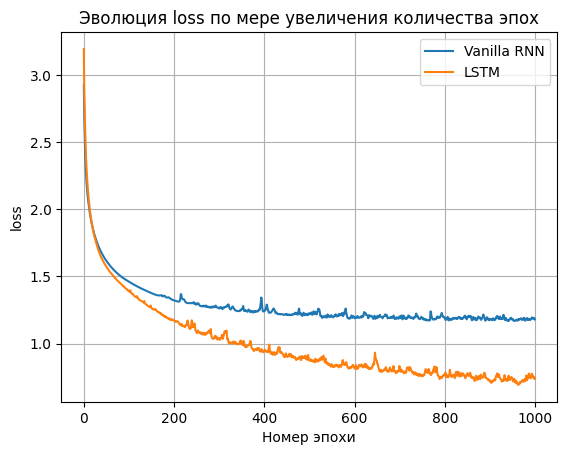

In [19]:
plt.plot(history_rnn, label='Vanilla RNN')
plt.plot(history_lstm, label='LSTM')
plt.legend()
plt.grid(True)
plt.xlabel('Номер эпохи')
plt.ylabel('loss')
plt.title('Эволюция loss по мере увеличения количества эпох')
plt.show()

Starting from the 100th epoch LSTM model gives significantly better loss.
Besides, loss curve for Vanilla RNN goes on a shelve already after 400th epoch

In [20]:
def generate_sample(model, seed_phrase='start ', max_length=500, temperature=1.0):
    
    model.eval()
    hidden = model.init_hidden(1)
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    generated_text = seed_phrase

    for _ in range(max_length - len(seed_phrase)):
        out, hidden = model(x_sequence, hidden)
        p_next = F.softmax(out.squeeze().div(temperature), dim=-1)
        next_ix = torch.multinomial(p_next, 1)[-1].item()
        generated_text += id_to_token[next_ix]
        # подадим новый токен next_ix на вход следующей иттерации
        x_sequence = torch.tensor([[next_ix]], dtype=torch.int64)
        
    return generated_text

In [21]:
# пример сгенерированного текста
print(generate_sample(model_lstm, max_length=500, temperature=1.0))

start now can still well.
  in natue,
  if winder's dassard's have grace;
 
  another's true,
  when sure that black and trmanded,
  doth live to wire could his rice
  to in this him with all true a keepy need
  prowing and died not lear'd wo,
  what dust speaking of worth do false remay;
  fits died and i most and injudies no part,
    'force i form days of pary to death:
  his thrive of ever light knows have ares
  if thou when i lay, is to my love,
  that my limst in thy self art, and perse,



Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

We can evaluate the results visually and try to interpret them.

In [22]:
# При маленьких темературах текст почти одинаковый, а при больших полный рандом
for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f'Temperature: {temperature}')
    for _ in range(5):
        print(generate_sample(model_lstm, max_length=200, temperature=temperature))
        print('-'*60)
    print('='*60)

Temperature: 0.1
start uple most.

  v

  to my lims that keepul sland,
  as your face that is all my amiss,
  and proud of thy sweet self a bred,
    and that thou waste of self dost thou desire
  that why doth in th
------------------------------------------------------------
start uple most.

  v

  to my lims that keepul sland,
  as your face that wantull i am desire?
, love, what down and think the widow do i not
  to better part of souls, and yet thine own bad.

  xxvi
------------------------------------------------------------
start uple most.

  v

  to my lims that pride so belies of thee.

  lxxvi

  is my love shall stars of love wast is thine
  since each dotions im thy strail'd fair,
  whilst i thou proves to be not s
------------------------------------------------------------
start uple most.

  v

  to my lims that keepul sland,
  as your sweet form winder of say all intory,
  whilst her eyel, which i have her party
  to me than thou wilt love of thee.

  lxxiv

  beno

### Interpretation of results: 
For low temperature we mostly have the same texts. We can often see such repeating parts as "start uple most" or "to my lims that". 
The text looks like the set of phrases that goes on by one, and each of them has only a few subsequent options. That makes a very limited number of different texts.

With increasing temperature text becames more variable, but at high temperatures it looks like just a random sequence of chars.

The best visible/readable text is with tempretaure = 1.0. Textes differes and still mostly use existing words.


However, even with tempretaure = 1.0, the sense of text and logical narrative are still require improvement.

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)